In [45]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.preprocessing.image import array_to_img, save_img

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import time
from os import listdir
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
%matplotlib inline


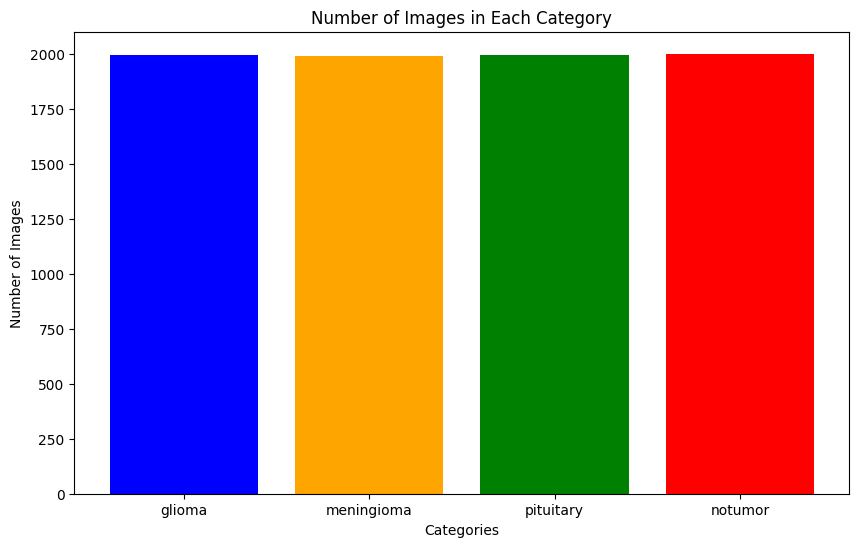

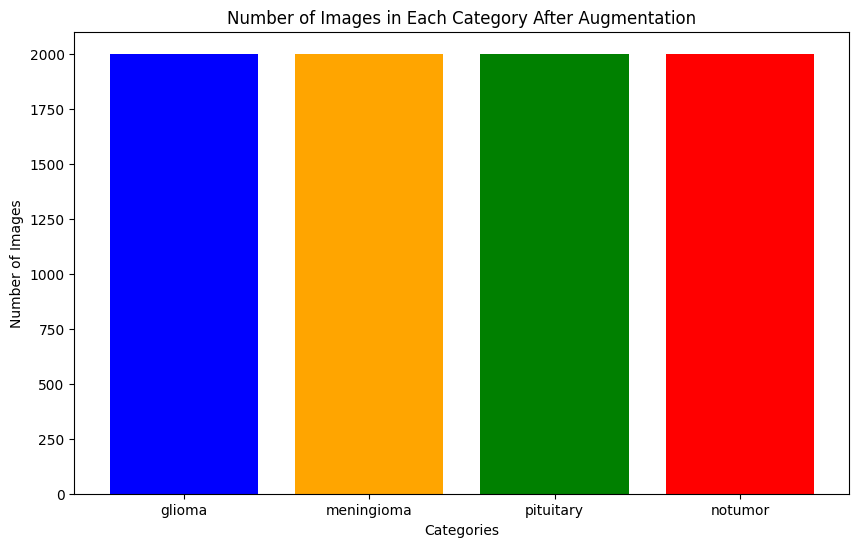

Found 6400 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.
Data preprocessing and augmentation complete.


In [13]:
# Define the directory path
dataset_dir = r'C:\Users\meera\Documents\BTech CSE spl. AIML\VS code\CHAIR Intership\Dataset'  # replace with your actual dataset path

# Initialize variables
categories = ['glioma', 'meningioma', 'pituitary', 'notumor']
image_count = {}

# Count the number of images in each category
for category in categories:
    category_dir = os.path.join(dataset_dir, category)
    image_count[category] = len(os.listdir(category_dir))

# Plot a bar graph to show the number of images in each category
plt.figure(figsize=(10, 6))
plt.bar(image_count.keys(), image_count.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.show()

# Get the maximum number of images in the "no_tumor" category
max_images = image_count['notumor']

# Data augmentation configuration
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda x: rgb_to_grayscale(x)
)

# Function to generate augmented images
def augment_images(category):
    category_dir = os.path.join(dataset_dir, category)
    images = os.listdir(category_dir)
    
    num_to_generate = max_images - len(images)
    generated = 0
    
    for image_name in images:
        image_path = os.path.join(category_dir, image_name)
        image = load_img(image_path)
        x = img_to_array(image)
        x = np.expand_dims(x, axis=0)
        
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=category_dir, save_prefix='aug', save_format='jpeg'):
            i += 1
            generated += 1
            if generated >= num_to_generate:
                break
        if generated >= num_to_generate:
            break

# Generate images for each category except "no_tumor"
for category in categories:
    if category != 'notumor':
        augment_images(category)

# Recalculate image counts after augmentation
image_count = {}
for category in categories:
    category_dir = os.path.join(dataset_dir, category)
    image_count[category] = len(os.listdir(category_dir))

# Plot a new bar graph to show the number of images in each category after augmentation
plt.figure(figsize=(10, 6))
plt.bar(image_count.keys(), image_count.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category After Augmentation')
plt.show()

# Create generators for training and validation data
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2, preprocessing_function=lambda x: rgb_to_grayscale(x))

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),  # adjust the size according to your needs
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),  # adjust the size according to your needs
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

print("Data preprocessing and augmentation complete.")


In [19]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image



In [27]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
        image_size: tuple of (image_width, image_height)
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    # Mapping of folder names to labels
    label_map = {
        'glioma': 0,
        'meningioma': 1,
        'pituitary': 2,
        'notumor': 3
    }
    
    # Initialize lists to store images and labels
    X = []
    y = []
    image_width, image_height = image_size
    
    # Load and process images from each directory
    for directory in dir_list:
        label = label_map[os.path.basename(directory)]
        for filename in listdir(directory):
            # Load the image
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
            if image is None:
                continue
            # Resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # Convert image to grayscale
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Normalize values
            image = image / 255.0
            # Expand dimensions to match the expected input shape for neural networks
            image = np.expand_dims(image, axis=-1)
            # Append image to X
            X.append(image)
            # Append label to y
            y.append([label])
                
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [28]:
# Define paths to your augmented data
augmented_path = 'C:\\Users\\meera\\Documents\\BTech CSE spl. AIML\\VS code\\CHAIR Intership\\Dataset'

# Augmented data for each category
augmented_glioma = os.path.join(augmented_path, 'glioma')
augmented_meningioma = os.path.join(augmented_path, 'meningioma')
augmented_pituitary = os.path.join(augmented_path, 'pituitary')
augmented_notumor = os.path.join(augmented_path, 'notumor')

# List of directories
dir_list = [
    augmented_glioma,
    augmented_meningioma,
    augmented_pituitary,
    augmented_notumor
]

# Define the image size
IMG_WIDTH, IMG_HEIGHT = (240, 240)

# Load data
X, y = load_data(dir_list, (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 8000
X shape is: (8000, 240, 240, 1)
y shape is: (8000, 1)


In [29]:
def plot_sample_images(X, y, label_names=['Glioma', 'Meningioma', 'Pituitary', 'No Tumor'], n=50):
    """
    Plots n sample images for each category based on y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
        label_names: List of label names corresponding to the categories.
        n: Number of sample images to plot for each category.
    """
    
    num_classes = len(label_names)
    
    for label in range(num_classes):
        # Grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)[:, 0]]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(np.ceil(n / columns_n))
        
        plt.figure(figsize=(20, 10))
        
        for i in range(len(n_images)):
            plt.subplot(rows_n, columns_n, i + 1)
            plt.imshow(n_images[i][:, :, 0], cmap='gray')  # Show grayscale images
            
            # Remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            plt.title(label_names[label])  # Set title based on label name
        
        plt.suptitle(f"Sample images of {label_names[label]}")
        plt.tight_layout()
        plt.show()

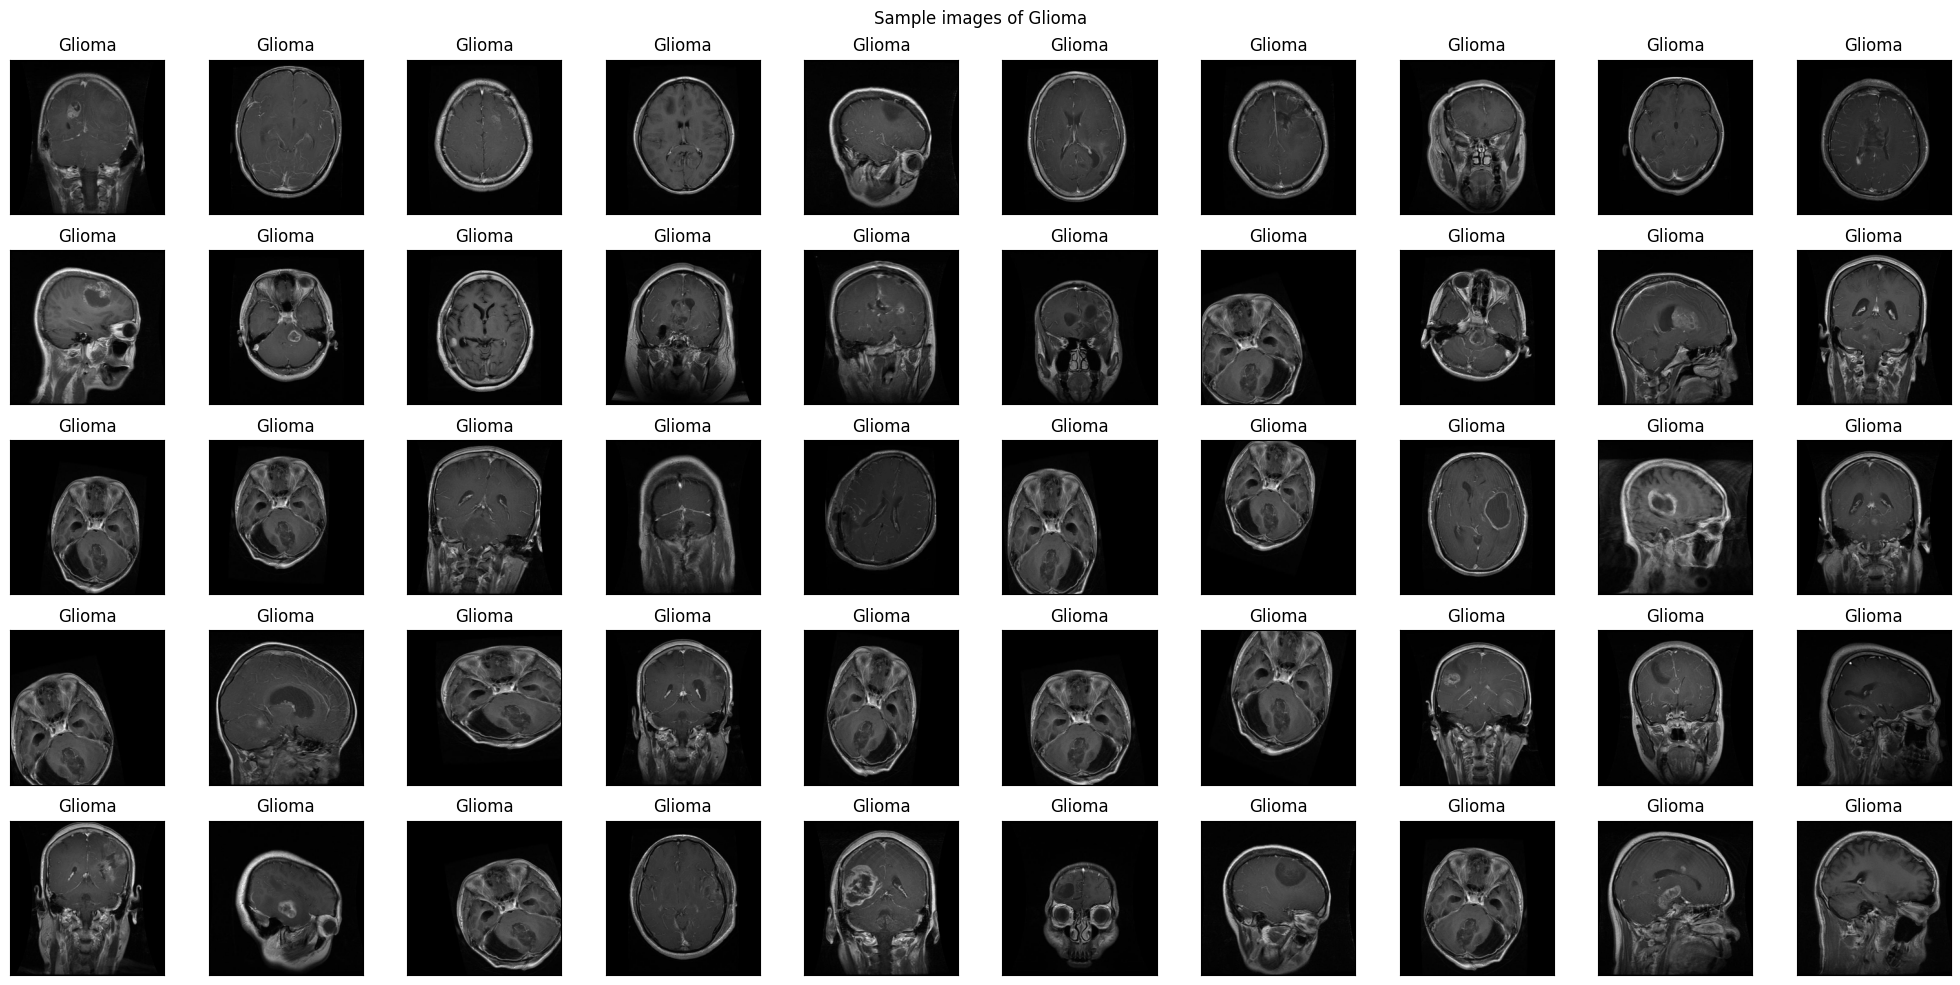

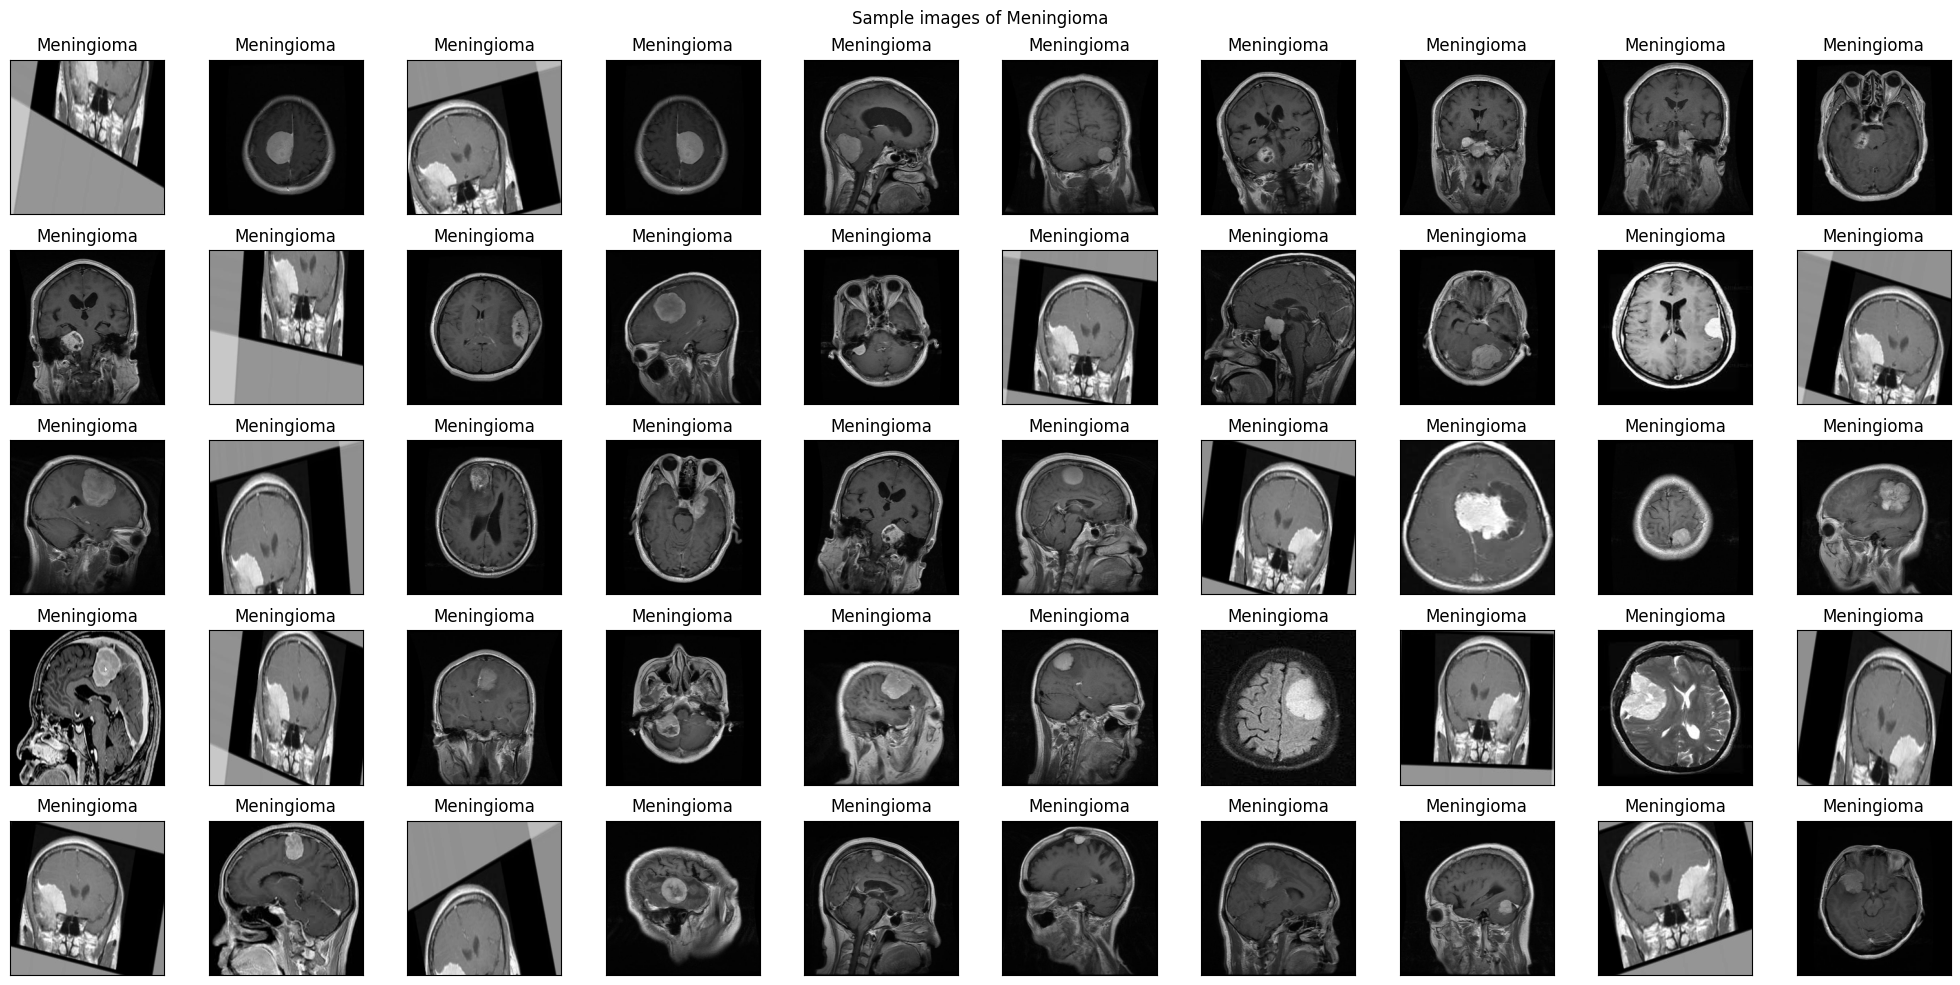

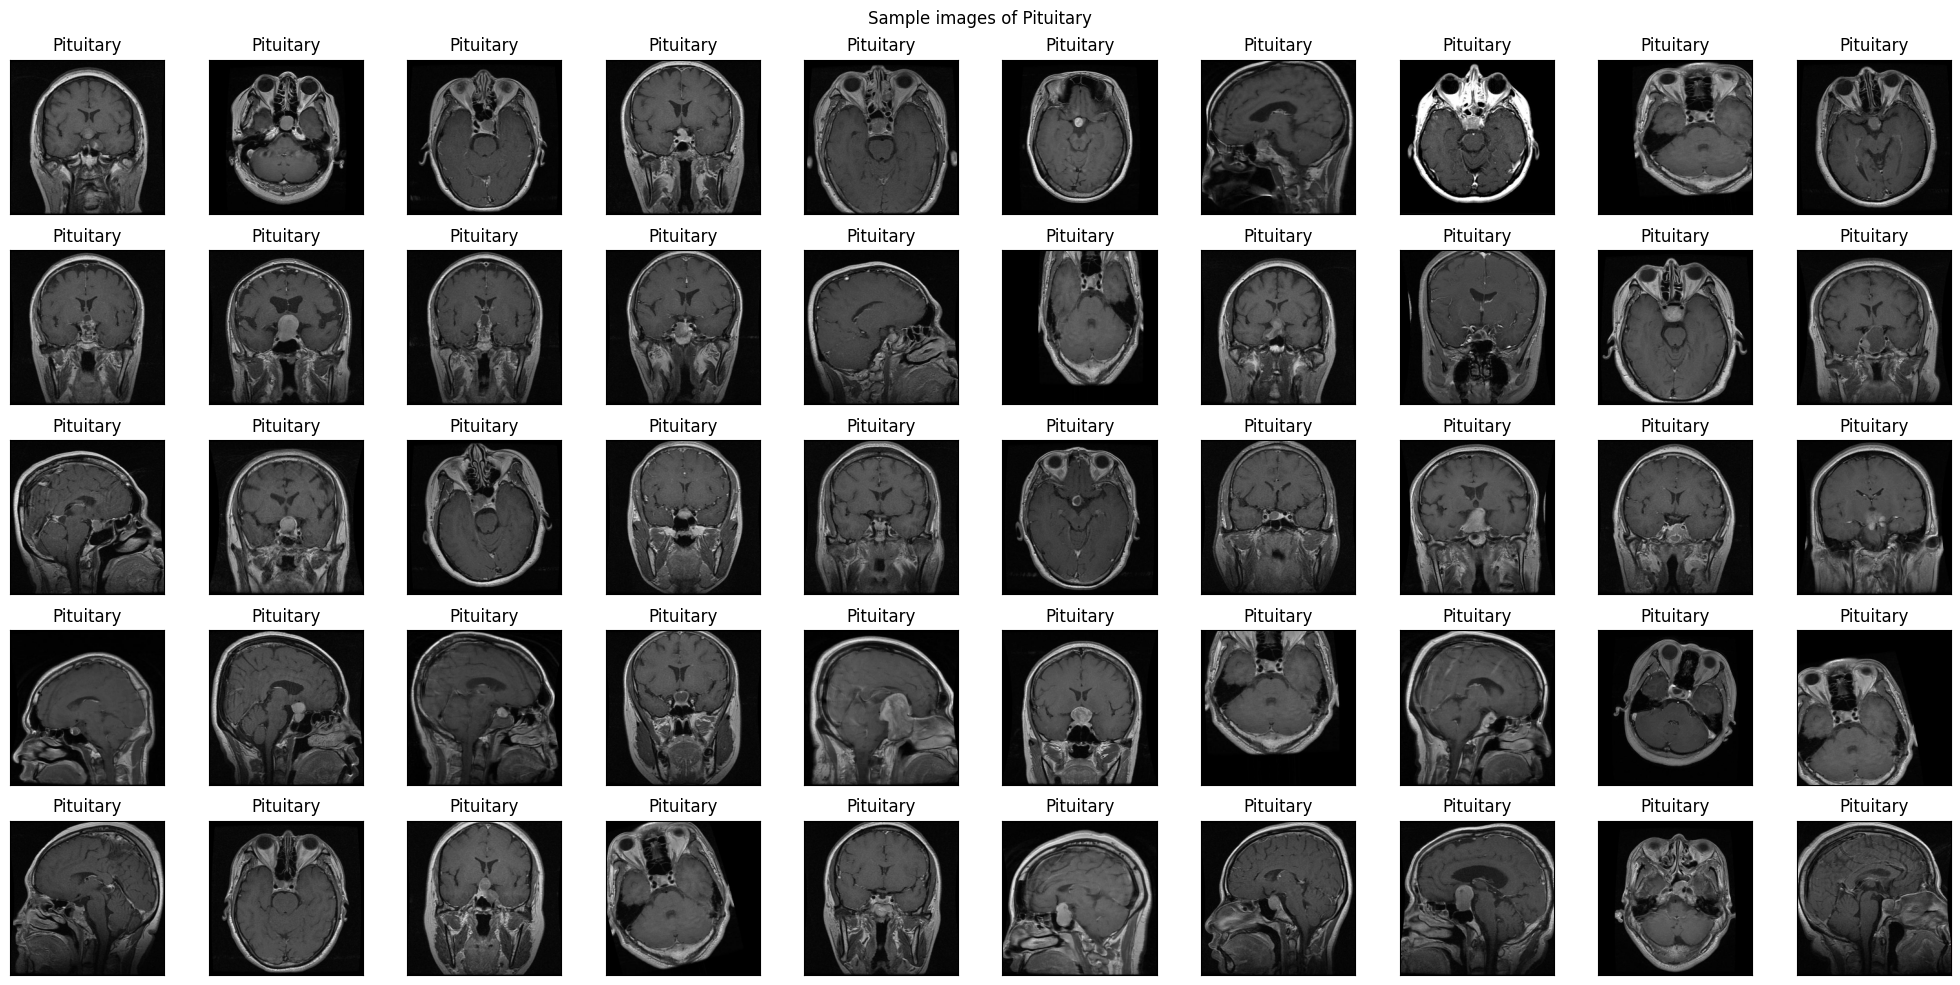

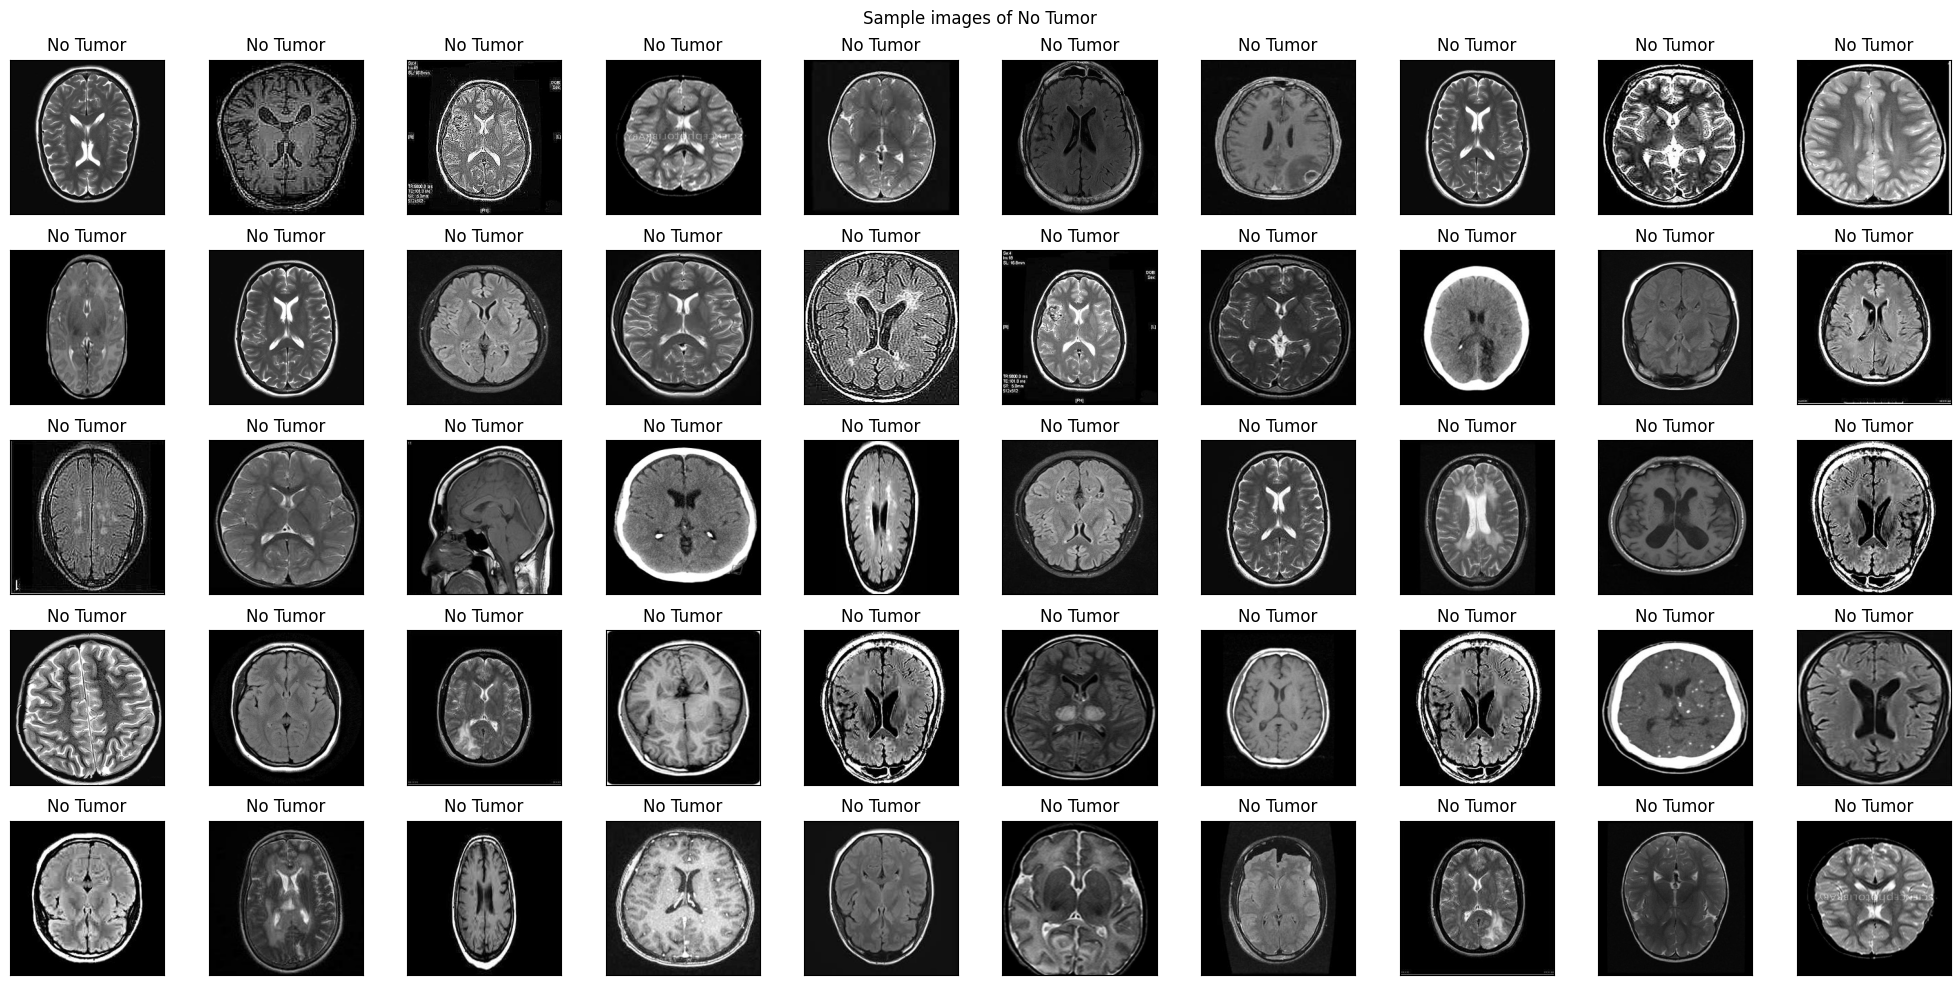

In [30]:
label_names = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

# Plot sample images
plot_sample_images(X, y, label_names=label_names, n=50)

In [50]:
def split_data(X, y, test_size=0.2):
    """
    Splits data into training, development, and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
        test_size: Fraction of data to reserve for test set (default is 0.2)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, num_classes) after one-hot encoding
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, num_classes) after one-hot encoding
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, num_classes) after one-hot encoding
    """
    
    # Split into train and combined test/validation
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Further split test/validation into separate test and validation sets
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
    
    # Convert labels to one-hot encoding
    num_classes = len(np.unique(y))  # Number of unique classes in y
    
    y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
    y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
    y_test_one_hot = to_categorical(y_test, num_classes=num_classes)
    
    return X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot

In [51]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 5600
number of development examples = 1200
number of test examples = 1200
X_train shape: (5600, 240, 240, 1)
Y_train shape: (5600, 4)
X_val (dev) shape: (1200, 240, 240, 1)
Y_val (dev) shape: (1200, 4)
X_test shape: (1200, 240, 240, 1)
Y_test shape: (1200, 4)


In [52]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [53]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [57]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(4, activation='softmax', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [58]:
# Build the model
input_shape = (240, 240, 1)
model = build_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

# checkpoint
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [59]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 240, 240, 1)]     0         
                                                                 
 zero_padding2d_5 (ZeroPadd  (None, 244, 244, 1)       0         
 ing2D)                                                          
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      1600      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation_5 (Activation)   (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [61]:
start_time = time.time()

# Train the model with the callbacks
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[reduce_lr, early_stopping, checkpoint, tensorboard])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
175/175 [==============================] - 147s 831ms/step - loss: 0.2117 - accuracy: 0.9252 - val_loss: 0.2976 - val_accuracy: 0.9008 - lr: 0.0010
Epoch 2/10
175/175 [==============================] - 149s 853ms/step - loss: 0.1806 - accuracy: 0.9350 - val_loss: 0.2641 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 3/10
175/175 [==============================] - 1030s 6s/step - loss: 0.1834 - accuracy: 0.9304 - val_loss: 0.4261 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 4/10
175/175 [==============================] - 143s 815ms/step - loss: 0.1380 - accuracy: 0.9496 - val_loss: 0.3479 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 5/10
175/175 [==============================] - 314s 2s/step - loss: 0.1294 - accuracy: 0.9550 - val_loss: 0.2728 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 6/10
175/175 [==============================] - 173s 987ms/step - loss: 0.2001 - accuracy: 0.9245 - val_loss: 0.4195 - val_accuracy: 0.8617 - lr: 0.0010
Epoch 7/10
175/175 [==============================]

In [67]:
def preprocess_image(img_path, target_size):
    # Load the image
    image = cv2.imread(img_path)
    # Crop the brain contour
    image = crop_brain_contour(image)
    # Resize the image
    image = cv2.resize(image, target_size)
    # Convert the image to grayscale if the model expects a single channel input
    if model.input_shape[-1] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)  # Add the channel dimension
    
    # Normalize the image
    image = image / 255.0
    # Expand dimensions to match the model's input shape (1, image_width, image_height, channels)
    image = np.expand_dims(image, axis=0)
    return image

In [68]:
def predict_and_classify(model, img_path, class_labels):
    # Preprocess the image
    preprocessed_image = preprocess_image(img_path, (IMG_WIDTH, IMG_HEIGHT))
    # Make a prediction
    prediction = model.predict(preprocessed_image)
    # Get the class index with the highest probability
    class_idx = np.argmax(prediction, axis=-1)[0]
    # Map the class index to the class label
    class_label = class_labels[class_idx]
    return class_label

In [71]:
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Path to the saved model
model_path = 'C:\\Users\\meera\\Documents\\BTech CSE spl. AIML\\VS code\\CHAIR Intership\\best_model.h5'

# Load the model
model = load_model(model_path)

# Path to the test image
img_path = "C:\\Users\\meera\\Downloads\\mri_gbm3.jpg"

# Predict and classify the test image
predicted_class = predict_and_classify(model, img_path, class_labels)

print(f'The predicted class for the test image is: {predicted_class}')

1/1 [==============================] - 0s 301ms/step
The predicted class for the test image is: pituitary
